图像退化叠加噪声，如何进行图像恢复。
首先处理噪声，1.对于周期性噪声，可以采用傅里叶变换进行处理，2。对于椒盐噪声，可以将一个完全一致的灰度图片，找到噪点信息，最终处理即可。
常见噪声恢复，
    1.ontraharmonic mean filter, Q>0适合胡椒噪声，Q<0适合盐噪声,Q=0是均值滤波器，Q=-1是harmonic mean filter
    2.geometric mean filter几何平均滤波器，细节保留一般比均值滤波器更好一点。都是处理高丝噪声
    3.统计排序滤波器，中值滤波起，最大值滤波器，最小值滤波器，alpha-trimmed mean filter既可以处理椒盐噪声
    4.Adaptive Median filters自适应中值滤波器，首先判断中间值是否为极值，如果是则扩大窗口，如果不是极值，如果原本的直不是极值，则输出原来的值。
对于退化图像恢复：
    1.对于退化函数的估计，抽取小区域，估计原本信号的傅立叶原本变换，然后使用当前傅立叶变换除以估计直，就获得估计的退化函数
        还有一种方法，拍摄小亮点，图像频谱直接除以亮点强度，就得到估计的退化函数
    2.恢复图像的方法，直接进行逆滤波。但是在高频段会严重放大噪声，因此可以采取低通滤波处理
        另一种方法，维纳滤波器，这个很难用，它需要原始图像的功率谱，有种骑驴找驴的效果。constrained least squares filtering,也是采用低通的感觉。

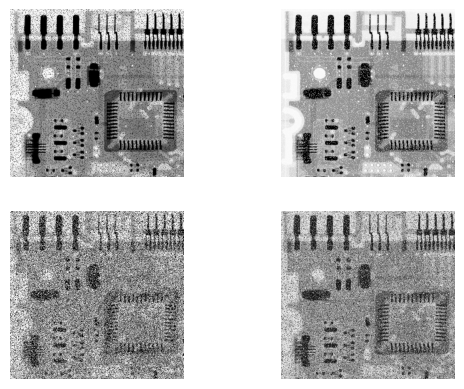

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
img1 = cv2.imread('Q6_1_1.tif',cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('Q6_1_2.tif', cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread('Q6_1_3.tif', cv2.IMREAD_GRAYSCALE)
img4 = cv2.imread('Q6_1_4.tif', cv2.IMREAD_GRAYSCALE)

def show_img(img,pos):
    plt.subplot(2,2,pos)
    plt.imshow(img,cmap='gray')
    plt.axis('off')
show_img(img1,1)
show_img(img2,2)
show_img(img3,3)
show_img(img4,4)


[[248.      248.      248.      ... 247.76051 247.6003  247.6003 ]
 [248.      248.      248.      ... 247.72044 247.6003  247.6003 ]
 [248.      248.      248.      ... 247.84065 247.80067 247.80067]
 ...
 [232.      232.      232.      ... 157.98924 158.78783 162.79893]
 [232.      232.      232.      ... 157.92714 159.17982 163.58011]
 [232.      232.      232.      ... 157.53833 158.80637 163.81287]]


/tmp/ipykernel_3198/3584239502.py:13: RuntimeWarning: divide by zero encountered in divide
  denominator = np.sum((1/neighborhood)**(-Q))


[[248.27261 248.27261 248.27261 ... 248.89067 249.87123 251.02304]
 [248.54582 248.54582 248.54582 ... 248.85054 249.5951  250.18884]
 [248.81964 249.09406 249.09406 ... 248.9308  249.71622 250.26996]
 ...
 [232.84006 234.53853 234.53853 ... 169.6712  168.22612 169.39307]
 [232.84006 233.6862  233.6862  ... 166.12408 164.81184 166.33344]
 [232.      232.84006 232.84006 ... 163.17879 161.86559 166.6219 ]]


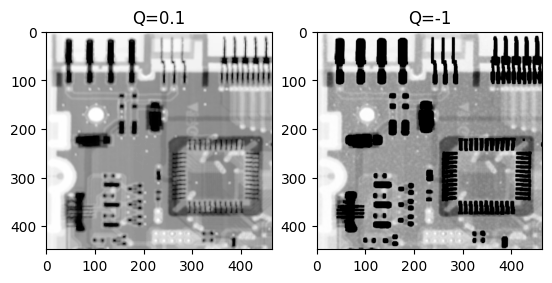

In [2]:

def contraharmonic_mean_filter(image, Q, kernel_size):
    pad = kernel_size // 2
    padded_image = np.pad(image, ((pad, pad), (pad, pad)), mode='edge')
    filtered_image = np.zeros_like(image, dtype=np.float32)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            neighborhood = padded_image[i:i + kernel_size, j:j + kernel_size]
            numerator = np.sum(neighborhood**(Q + 1))
            if Q >=0:
                denominator = np.sum(neighborhood**Q)
            else:
                denominator = np.sum((1/neighborhood)**(-Q))
            if denominator != 0:  # 避免除以零的情况
                filtered_image[i, j] = numerator / denominator
            else:
                filtered_image[i, j] = neighborhood[pad, pad]  # 保持原值
    print(filtered_image)
    return np.uint8(np.clip(filtered_image, 0, 255))  # 限制输出像素值范围
img1_filtered = contraharmonic_mean_filter(img1,0.3,5)
img2_filtered = contraharmonic_mean_filter(img2,-1,5)
plt.subplot(121), plt.imshow(img1_filtered, cmap='gray'), plt.title('Q=0.1')
plt.subplot(122), plt.imshow(img2_filtered, cmap='gray'), plt.title('Q=-1')
plt.show()


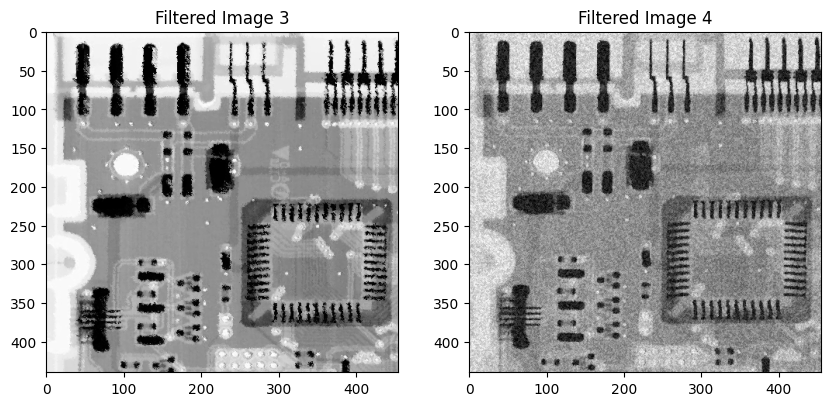

In [3]:
def is_normal(pixel_value, min_val, max_val):
    return pixel_value > min_val and pixel_value < max_val

def adaptive_median_filter(image, max_window_size=7):
    pad = max_window_size // 2
    padded_image = np.pad(image, ((pad, pad), (pad, pad)), mode='edge')
    filtered_image = np.copy(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # 从 3x3 窗口开始，逐渐增加直到最大窗口大小
            for window_size in range(3, max_window_size + 1, 2):
                pad = window_size // 2
                neighborhood = padded_image[i:i + window_size, j:j + window_size]
                median_value = np.median(neighborhood)
                min_val = np.min(neighborhood)
                max_val = np.max(neighborhood)
                if (is_normal(median_value, min_val, max_val)):
                # 检查条件
                    if (is_normal(padded_image[i + pad, j + pad], min_val, max_val)):
                        filtered_image[i, j] = padded_image[i + pad, j + pad]
                    else:
                        filtered_image[i, j] = median_value  # 保留原值
                    break  # 一旦处理完，就结束当前窗口大小的循环
                if (window_size == max_window_size):
                    filtered_image[i, j] = median_value  # 保留原值

    return np.uint8(np.clip(filtered_image, 0, 255))  # 限制输出像素值范围
img3_filtered = adaptive_median_filter(img3, max_window_size=15)
img4_filtered_median = adaptive_median_filter(img4, max_window_size=7)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img3_filtered, cmap='gray')
axes[0].set_title('Filtered Image 3')
axes[1].imshow(img4_filtered_median, cmap='gray')
axes[1].set_title('Filtered Image 4')
plt.show()

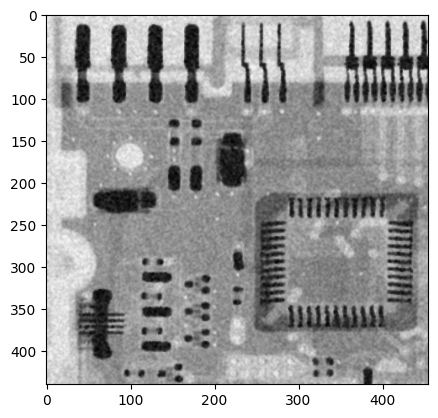

In [19]:
def geometric_mean_filter(image, kernel_size):
    pad = kernel_size // 2
    padded_image = np.pad(image, ((pad, pad), (pad, pad)), mode='edge')
    filtered_image = np.zeros_like(image, dtype=np.float32)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            neighborhood = padded_image[i:i + kernel_size, j:j + kernel_size].astype(np.float32)  # 转换为浮点型
            if np.any(neighborhood <= 0):  # 防止负值或零影响几何均值
                filtered_image[i, j] = 0
            else:
                filtered_image[i, j] = np.prod(neighborhood) ** (1.0 / (kernel_size * kernel_size))

    return np.uint8(np.clip(filtered_image, 0, 255))  # 限制输出像素值范围

img4_filtered = geometric_mean_filter(img4_filtered_median, 3)
plt.imshow(img4_filtered, cmap='gray')

Text(0.5, 1.0, 'Median Filter')

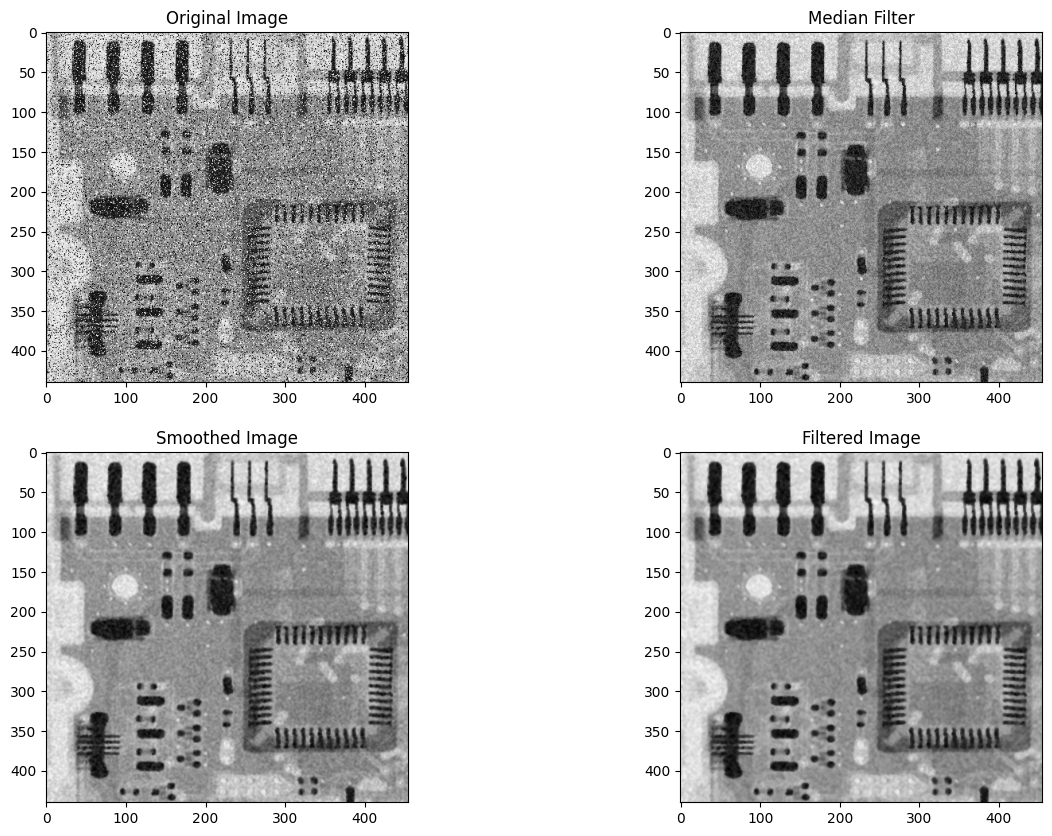

In [38]:

def alpha_mean_trimmed_filter(image, kernel_size, alpha):
    pad = kernel_size // 2
    padded_image = np.pad(image, ((pad, pad), (pad, pad)), mode='edge')
    filtered_image = np.zeros_like(image, dtype=np.float32)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            neighborhood = padded_image[i:i + kernel_size, j:j + kernel_size].astype(np.float32)  # 转换为浮点型
            sorted_neighbors = np.sort(neighborhood, axis=None)  # 将邻域像素展平并排序

            # 计算修剪的数量
            trim_amount = int(alpha * kernel_size * kernel_size)
            # 修剪最低和最高的 α% 像素值
            trimmed_neighbors = sorted_neighbors[trim_amount:-trim_amount] if trim_amount < len(sorted_neighbors) // 2 else sorted_neighbors
            
            if len(trimmed_neighbors) > 0:
                filtered_image[i, j] = np.mean(trimmed_neighbors)  # 计算均值

    return np.uint8(np.clip(filtered_image, 0, 255))  # 限制输出像素值范围

img4_smoothed = geometric_mean_filter(img4_filtered_median, 3)
img4_filtered = cv2.medianBlur(img4_smoothed, 3)
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 3)
plt.imshow(img4_smoothed, cmap='gray')
plt.title('Smoothed Image')
plt.subplot(2, 2, 4)
plt.imshow(img4_filtered, cmap='gray')
plt.title('Filtered Image')
plt.subplot(2, 2, 1)
plt.imshow(img4, cmap='gray')
plt.title('Original Image')
plt.subplot(2, 2, 2)
plt.imshow(img4_filtered_median, cmap='gray')
plt.title('Median Filter')

# img4_filtered = alpha_mean_trimmed_filter(img4_filtered_median, 3, 0.4)

# img4_filtered_median2 = adaptive_median_filter(img4_filtered_median, 3)

# plt.figure(figsize=(15, 10))
# plt.subplot(2, 2, 1)
# plt.imshow(img4_filtered_median, cmap='gray')
# plt.title('Median Filter')
# plt.subplot(2, 2, 2)
# plt.imshow(img4_filtered, cmap='gray')
# plt.title('Alpha-Mean Trimmed Filter')
# plt.subplot(2, 2, 3)
# plt.imshow(img4_filtered_median2, cmap='gray')
# plt.title('Adaptive Median Filter')
# plt.subplot(2, 2, 4)
# plt.imshow(img4, cmap='gray')
# plt.title('Original Image')
#对原始图像进行4次中值滤波
# img4_filtered_median4 = cv2.medianBlur(img4_filtered_median, 3)

# img4_filtered_median4 = cv2.medianBlur(img4_filtered_median4, 3)
# img4_filtered_median4 = cv2.medianBlur(img4_filtered_median4, 3)
# img4_filtered_median4 = cv2.medianBlur(img4_filtered_median4, 3)
# plt.figure(figsize=(15, 10))
# plt.subplot(2, 2, 1)
# plt.imshow(img4_filtered_median2, cmap='gray')
# plt.title('Adaptive Median Filter')
# plt.subplot(2, 2, 2)
# plt.imshow(img4_filtered_median4, cmap='gray')
# plt.title('4x Median Filter')
# plt.subplot(2, 2, 3)
# plt.imshow(img4, cmap='gray')
# plt.title('Original Image')
# plt.subplot(2, 2, 4)
# plt.imshow(img4_filtered, cmap='gray')
# plt.title('Alpha-Mean Trimmed Filter')

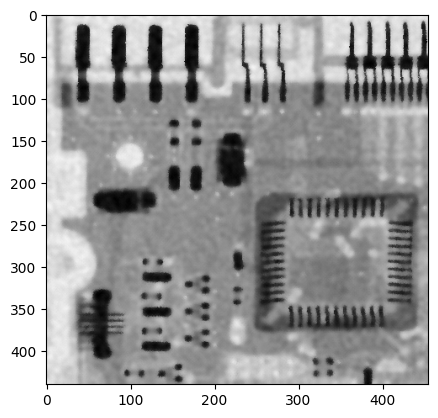

In [ ]:
# 计算傅里叶变换
def show_fft(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)  # 将低频移到中心

    # 计算幅度谱并取对数
    magnitude_spectrum = np.log(np.abs(fshift) + 1)  # 加1避免对数零
    plt.imshow(magnitude_spectrum, cmap='gray')
# show_fft(img4)
# show_fft(img4_smoothed)
#显示直方图
def show_hist(img):
    hist,_ = np.histogram(img.flatten(), bins=256, range=(0, 255))
    plt.plot(hist)
# show_hist(img4)
# show_hist(img4_filtered_median)
# show_hist(img3)
#双边滤波
# img4_filtered_bilateral = cv2.bilateralFilter(img4_filtered_median, 9, 75, 75)
# plt.imshow(img4_filtered_bilateral, cmap='gray')

In [ ]:
from ipywidgets import interact
img5 = cv2.imread('Q6_2.tif', cv2.IMREAD_GRAYSCALE)
k=0.0025
N,M = img5.shape
u,v = np.meshgrid(np.arange(M)-M/2, np.arange(N)-N/2)

H = np.exp(-k*((u**2 + v**2)**(5/6)))

def radially_limited_inverse_filtering(image, H,D0):
    # 计算图像的FFT
    G = np.fft.fft2(image)
    G_shifted = np.fft.fftshift(G)
    
    #创建理想低通滤波器
    x = np.linspace(-N/2, N/2-1, N)
    y = np.linspace(-M/2, M/2-1, M)
    X, Y = np.meshgrid(x, y)

    # 计算每个点到中心的距离
    D = np.sqrt(X**2 + Y**2)
    # 创建理想低通滤波器
    H_ideal = np.zeros_like(D)
    H_ideal[D <= D0] = 1  
    
    
    # 进行逆滤波
    F_shifted = G_shifted / (H + 1e-10)  # 防止除以零
    F_shifted = F_shifted * H_ideal
    
    F = np.fft.ifftshift(F_shifted)
    F_result = np.fft.ifft2(F)
    F_result = np.real(F_result)

    # 归一化处理以适应图像格式
    F_result = np.clip(F_result, 0, 255).astype(np.uint8)
    
    return F_result
def update_d0(D0):
    img5_filtered = radially_limited_inverse_filtering(img5, H, D0)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    
    plt.imshow(img5, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    
    plt.imshow(img5_filtered, cmap='gray')
    plt.axis('off')
    
    plt.show()

# 使用ipywidgets创建交互式滑块
interact(update_d0, D0=(0, 200, 1)) 
#94发现可以比较好的去除噪声

[[-240. -239. -238. ...  237.  238.  239.]
 [-240. -239. -238. ...  237.  238.  239.]
 [-240. -239. -238. ...  237.  238.  239.]
 ...
 [-240. -239. -238. ...  237.  238.  239.]
 [-240. -239. -238. ...  237.  238.  239.]
 [-240. -239. -238. ...  237.  238.  239.]]


interactive(children=(IntSlider(value=100, description='D0', max=200), Output()), _dom_classes=('widget-intera…

<function __main__.update_d0(D0)>

In [ ]:
def wiener_filter(image, H,K):
    # 计算图像的FFT
    G = np.fft.fft2(image)
    G_shifted = np.fft.fftshift(G)
    
    F_shifted = G_shifted*H.conj()/(np.abs(H)**2+K)
    
    F = np.fft.ifftshift(F_shifted)
    F_result = np.fft.ifft2(F)
    F_result = np.real(F_result)

    # 归一化处理以适应图像格式
    F_result = np.clip(F_result, 0, 255).astype(np.uint8)
    
    
    return F_result

def update_K(K):
    img5_filtered = wiener_filter(img5, H, K)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    
    plt.imshow(img5, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    
    plt.imshow(img5_filtered, cmap='gray')
    plt.axis('off')
    
    plt.show()

# 使用ipywidgets创建交互式滑块
interact(update_K, K=(0, 5e-5, 0.00001)) 
# 注意：K的取值范围为0到5e-5，步长为0.00001

[[1.17254363e-18 1.35294715e-18 1.56032887e-18 ... 1.79860010e-18
  1.56032887e-18 1.35294715e-18]
 [1.35294715e-18 1.56126248e-18 1.80075459e-18 ... 2.07594730e-18
  1.80075459e-18 1.56126248e-18]
 [1.56032887e-18 1.80075459e-18 2.07719116e-18 ... 2.39486819e-18
  2.07719116e-18 1.80075459e-18]
 ...
 [1.79860010e-18 2.07594730e-18 2.39486819e-18 ... 2.76140529e-18
  2.39486819e-18 2.07594730e-18]
 [1.56032887e-18 1.80075459e-18 2.07719116e-18 ... 2.39486819e-18
  2.07719116e-18 1.80075459e-18]
 [1.35294715e-18 1.56126248e-18 1.80075459e-18 ... 2.07594730e-18
  1.80075459e-18 1.56126248e-18]]


interactive(children=(FloatSlider(value=2e-05, description='K', max=5e-05, step=1e-05), Output()), _dom_classe…

<function __main__.update_K(K)>

[[1.17254363e-18 1.35294715e-18 1.56032887e-18 ... 1.79860010e-18
  1.56032887e-18 1.35294715e-18]
 [1.35294715e-18 1.56126248e-18 1.80075459e-18 ... 2.07594730e-18
  1.80075459e-18 1.56126248e-18]
 [1.56032887e-18 1.80075459e-18 2.07719116e-18 ... 2.39486819e-18
  2.07719116e-18 1.80075459e-18]
 ...
 [1.79860010e-18 2.07594730e-18 2.39486819e-18 ... 2.76140529e-18
  2.39486819e-18 2.07594730e-18]
 [1.56032887e-18 1.80075459e-18 2.07719116e-18 ... 2.39486819e-18
  2.07719116e-18 1.80075459e-18]
 [1.35294715e-18 1.56126248e-18 1.80075459e-18 ... 2.07594730e-18
  1.80075459e-18 1.56126248e-18]]
[[255   0 255 ...   0 255   0]
 [  0 255   0 ... 255   0 255]
 [255   0 255 ...   0 255   0]
 ...
 [  0 255   0 ... 255   0 255]
 [255   0 255 ...   0 255   0]
 [  0 255   0 ... 255   0 255]]


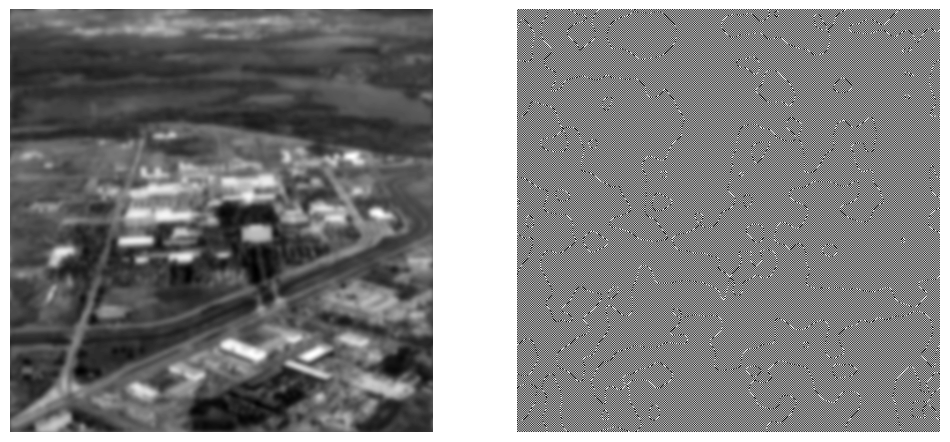

In [24]:
def full_inverse_filter(image, H):
    # 计算图像的FFT
    G = np.fft.fft2(image)
    G_shifted = np.fft.fftshift(G)
    
    F_shifted = G_shifted/H
    
    F = np.fft.ifftshift(F_shifted)
    F_result = np.fft.ifft2(F)
    F_result = np.real(F_result)

    # 归一化处理以适应图像格式
    F_result = np.clip(F_result, 0, 255).astype(np.uint8)
    
    print(F_result)
    return F_result
print(H.conj())
img5_filtered = full_inverse_filter(img5, H)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

plt.imshow(img5, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)

plt.imshow(img5_filtered, cmap='gray')
plt.axis('off')

plt.show()

# 使用ipywidgets创建交互式滑块
 
# 注意：K的取值范围为0到5e-5，步长为0.00001

Text(0.5, 1.0, 'Q6_3_3.tif')

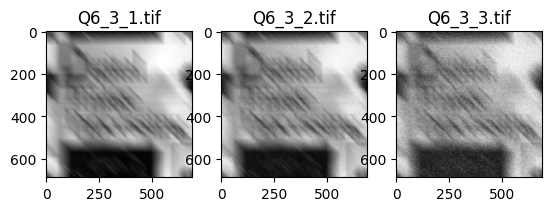

In [25]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 
img1 = cv2.imread('Q6_3_1.tif', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('Q6_3_2.tif', cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread('Q6_3_3.tif', cv2.IMREAD_GRAYSCALE)

plt.subplot(131)
plt.imshow(img1, cmap='gray')
plt.title('Q6_3_1.tif')

plt.subplot(132)
plt.imshow(img2, cmap='gray')
plt.title('Q6_3_2.tif')

plt.subplot(133)
plt.imshow(img3, cmap='gray')
plt.title('Q6_3_3.tif')

In [48]:
from ipywidgets import interact, FloatSlider
a,b=0.1,0.1
T=1
M,N = img1.shape
u,v = np.meshgrid(np.arange(M)-M/2,np.arange(N)-N/2)
print(u)
def get_motion_H(a,b,T):
    H = T/(np.pi*(u*a+v*b)+1e-10)*np.sin(np.pi*(u*a+v*b))*np.exp(-1j*np.pi*(u*a+v*b))
    return H
H = get_motion_H(a,b,T)
H1 = get_motion_H(-0.1,-0.1,1)
print(H)
k1 = 1e-8
k2 = 1e-3
k3 = 1e-1
img1_restored = wiener_filter(img1,H1,k1)
img2_restored = wiener_filter(img2,H,k2)
img3_restored = wiener_filter(img3,H,k1)
def update_images(k1, k2, k3):
    img1_restored = wiener_filter(img1, H, k1)
    img2_restored = wiener_filter(img2, H, k2)
    img3_restored = wiener_filter(img3, H, k3)

    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    axes[0].imshow(img1_restored, cmap='gray')
    axes[0].set_title(f'Restore Image 1\nk1={k1:.1e}')
    axes[1].imshow(img2_restored, cmap='gray')
    axes[1].set_title(f'Restore Image 2\nk2={k2:.1e}')
    axes[2].imshow(img3_restored, cmap='gray')
    axes[2].set_title(f'Restore Image 3\nk3={k3:.1e}')
    plt.show()

# 使用ipywidgets创建滑块
k1_slider = FloatSlider(value=1e-8, min=1e-11, max=1e-2, step=1e-10, description='k1')
k2_slider = FloatSlider(value=1e-3, min=1e-10, max=1e-2, step=1e-10, description='k2')
k3_slider = FloatSlider(value=1e-1, min=1e-10, max=1e-2, step=1e-10, description='k3')
interact(update_images, k1=k1_slider, k2=k2_slider, k3=k3_slider)

# fig, axes = plt.subplots(1, 3, figsize=(10, 5))
# axes[0].imshow(img1_restored, cmap='gray')
# axes[0].set_title('restore Image 1')
# axes[1].imshow(img2_restored, cmap='gray')
# axes[1].set_title('restore Image 2')
# axes[2].imshow(img3_restored, cmap='gray')
# axes[2].set_title('restore Image 3')
# plt.show()



[[-344. -343. -342. ...  341.  342.  343.]
 [-344. -343. -342. ...  341.  342.  343.]
 [-344. -343. -342. ...  341.  342.  343.]
 ...
 [-344. -343. -342. ...  341.  342.  343.]
 [-344. -343. -342. ...  341.  342.  343.]
 [-344. -343. -342. ...  341.  342.  343.]]
[[-2.20007770e-03+0.00159845j -2.20328014e-03+0.00303255j
  -1.36368700e-03+0.004197j   ...  5.04551152e-01+0.69445508j
   7.56826729e-01+0.5498668j   9.35489284e-01+0.30395889j]
 [-2.20328014e-03+0.00303255j -1.36368700e-03+0.004197j
  -2.29068630e-18+0.00464686j ...  7.56826729e-01+0.5498668j
   9.35489284e-01+0.30395889j  0.00000000e+00+0.j        ]
 [-1.36368700e-03+0.004197j   -2.29068630e-18+0.00464686j
   1.36767439e-03+0.00420927j ...  9.35489284e-01+0.30395889j
   0.00000000e+00+0.j          9.35489283e-01-0.30395889j]
 ...
 [ 5.04551152e-01+0.69445508j  7.56826729e-01+0.5498668j
   9.35489284e-01+0.30395889j ...  2.21943322e-03-0.00161251j
   2.21618369e-03-0.00305032j  1.36767439e-03-0.00420927j]
 [ 7.56826729e-01+0

interactive(children=(FloatSlider(value=1e-08, description='k1', max=0.01, min=1e-11, step=1e-10), FloatSlider…

<function __main__.update_images(k1, k2, k3)>